# PERFORMANCE METRICS 

Compute the performance metrics of the EIF and EIF+ models (for the moment let's consider just these two). 

Performance Metrics computed: 

1. The typical classification metrics that we can obtain with sklearn.metrics.classification_report

2. The Average Precision -> this is obtained with sklearn.metrics.average_precision_score but we can still use the mean value obtained in the Average_Precision.ipynb notebook (the ones used to create the Violin Plot)

3. The ROC AUC Score -> obtainable with the sklearn.metrics.auc_roc_score 

In [1]:
import sys
import numpy as np
from datetime import datetime
import pandas as pd
import argparse
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import sklearn
sys.path.append('../')
from utils import *
#from utils.feature_selection import *
from plot import *
from simulation_setup import *
from models import *
from models.forests import *
from models.Extended_IF import *
from models.Extended_DIFFI import *
from models.Extended_DIFFI_original import *
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,average_precision_score,roc_auc_score
import math
import seaborn as sns
sns.set()

import os
import pickle 
import scipy.io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
def partition_data(X,y):
    inliers=X[y==0,:]
    outliers=X[y==1,:]
    return inliers,outliers

In [3]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

# Synthetic Dataset

## Load pkl files

In [14]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [15]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [16]:
file_to_read = open(os.getcwd()+'\\anomalies.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d=loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisec'],loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_6d']

In [6]:
file_to_read = open(os.getcwd()+'\\syn_test_anomaly_interval.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisec = loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisect']

In [7]:
file_to_read = open(os.getcwd()+'\\syn_test_multi_dim_anomaly_interval.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_bisect_3d,X_bisect_6d = loaded_dictionary['X_bisect_3d'],loaded_dictionary['X_bisect_6d']

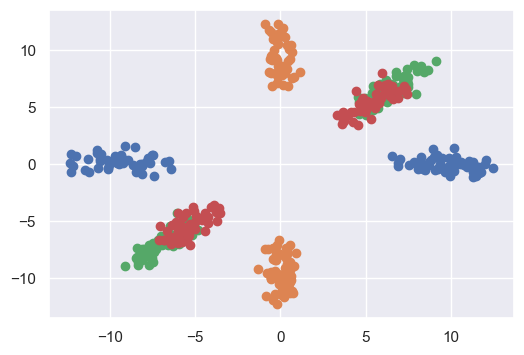

In [8]:
sns.set()
#plt.scatter(inliers[:,0],inliers[:,1])
fig=plt.figure(figsize=(6, 4))
fig.patch.set_alpha(0.5)
plt.scatter(X_xaxis[:,0],X_xaxis[:,1])
plt.scatter(X_yaxis[:,0],X_yaxis[:,1])
plt.scatter(X_bisect[:,0],X_bisect[:,1])
plt.scatter(X_bisect_3d[:,0],X_bisect_3d[:,1])
#plt.scatter(xy[:,0],xy[:,1])
#plt.legend(['x-axis Anomalies','y-axis Anomalies',
            #'Bisector Anomalies','Bisector 3d Anomalies'])
plt.show()

## Performance Report Table Computation Function

In [17]:
def csv_dataset(name, path = "../data/"):
    datapath = path + name + ".csv"
    data=pd.read_csv(datapath,index_col=0)
    if 'Unnamed: 0' in data.columns:
        data=data.drop(columns=['Unnamed: 0'])
    
    X=data[data.columns[data.columns!='Target']]
    y=data['Target']
    
    X,y = drop_duplicates(X,y)
    print(name, "\n")
    print_dataset_resume(X,y)
    
    return X,y

In [18]:
def if_predict(score,p):
    y=score>np.sort(score)[::-1][int(p*len(score))]
    return y.astype(int)

In [19]:
def performance_if(y,score):
    p=sum(y)/len(y)
    y_pred=if_predict(score,p)
    d={}
    d['Precision']=sklearn.metrics.precision_score(y,y_pred) 
    d['Recall']=sklearn.metrics.recall_score(y,y_pred) 
    d['f1 score']=sklearn.metrics.f1_score(y,y_pred) 
    d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred) 
    d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred) 
    d['Average Precision']=sklearn.metrics.average_precision_score(y,y_pred) 
    d['ROC AUC Score']=sklearn.metrics.roc_auc_score(y,y_pred) 
    return d

In [20]:
def performance_eif(y,score,X_test,model):
    p=sum(y)/len(y)
    y_pred=model._predict(X_test,p).astype(int)
    d={}
    d['Precision']=sklearn.metrics.precision_score(y,y_pred) 
    d['Recall']=sklearn.metrics.recall_score(y,y_pred)
    d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
    d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
    d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
    d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
    d['ROC AUC Score']=sklearn.metrics.roc_auc_score(y,score)
    return d

In [21]:
def evaluate_performance(X_train,X_test,y):
    
    EIF=ExtendedIsolationForest(n_estimators=300,plus=0)
    EIF.fit(X_train)

    EIF_plus=ExtendedIsolationForest(n_estimators=300,plus=1)
    EIF_plus.fit(X_train)

    IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),256))
    IF.fit(X_train)

    score_if=-1*IF.score_samples(X_test)+0.5
    score_eif=EIF.predict(X_test)
    score_eif_plus=EIF_plus.predict(X_test)

    metrics_if=performance_if(y,score_if)
    metrics_eif=performance_eif(y,score_eif,X_test,EIF)
    metrics_eif_plus=performance_eif(y,score_eif_plus,X_test,EIF_plus)

    return metrics_if,metrics_eif,metrics_eif_plus
    

In [31]:
metrics_dict['Xaxis']['IF'].keys()

dict_keys(['Precision', 'Recall', 'f1 score', 'Accuracy', 'Balanced Accuracy', 'Average Precision', 'ROC AUC Score'])

In [22]:
def collect_performance(metrics_dict,name,X_train,X_test,y):
    metrics_dict[name]={}
    metrics_dict[name]["IF"]={}
    metrics_dict[name]["EIF"]={}
    metrics_dict[name]["EIF_plus"]={}
    metric_names=['Precision', 'Recall', 'f1 score', 'Accuracy', 'Balanced Accuracy', 'Average Precision', 'ROC AUC Score']

    for metric_name in metric_names:
        metrics_dict[name]['IF'][metric_name]=[]
        metrics_dict[name]['EIF'][metric_name]=[]
        metrics_dict[name]['EIF_plus'][metric_name]=[]


    for i in tqdm(range(10)):
        metrics_if,metrics_eif,metrics_eif_plus=evaluate_performance(X_train,X_test,y)

        for metric_name in metric_names:
            metrics_dict[name]['IF'][metric_name].append(metrics_if[metric_name])
            metrics_dict[name]['EIF'][metric_name].append(metrics_eif[metric_name])
            metrics_dict[name]['EIF_plus'][metric_name].append(metrics_eif_plus[metric_name])

    for metric_name in metric_names:
        metrics_dict[name]['IF'][metric_name+'_avg']=np.mean(np.array(metrics_dict[name]['IF'][metric_name]))
        metrics_dict[name]['EIF'][metric_name+'_avg']=np.mean(np.array(metrics_dict[name]['EIF'][metric_name]))
        metrics_dict[name]['EIF_plus'][metric_name+'_avg']=np.mean(np.array(metrics_dict[name]['EIF_plus'][metric_name]))
     
    
    return metrics_dict

In [23]:
def performance_report(name,metrics_dict,metrics_dict_split):
    
    os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
    if name=='diabetes' or name=='moodify':
        X,y=csv_dataset(name,os.getcwd()+'\\')
    else:
        X,y=dataset(name,os.getcwd()+'\\')

    X,y=downsample(X,y)
    X_train,X_test=partition_data(X,y)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)

    #Compute Performance Report Table without split
    metrics_dict=collect_performance(metrics_dict,name,X,X,y)

    #Compute Performance Report Table with split
    metrics_dict_split=collect_performance(metrics_dict_split,name,X_train,X_test,y)

    print('--------------------------------------------------------')
    print(name)
    print()
    print('f1 score and average precision no train test split ')
    print(f'IF -> f1 score: {metrics_dict[name]["IF"]["f1 score"]}\naverage precision: {metrics_dict[name]["IF"]["Average Precision"]}')
    print(f'EIF -> f1 score: {metrics_dict[name]["EIF"]["f1 score"]}\naverage precision: {metrics_dict[name]["EIF"]["Average Precision"]}')
    print(f'EIF_plus -> f1 score: {metrics_dict[name]["EIF_plus"]["f1 score"]}\naverage precision: {metrics_dict[name]["EIF_plus"]["Average Precision"]}')
    print(' ')
    print('f1 score and average precision with train test split ')
    print(f'IF -> f1 score: {metrics_dict_split[name]["IF"]["f1 score"]}\naverage precision: {metrics_dict_split[name]["IF"]["Average Precision"]}')
    print(f'EIF -> f1 score: {metrics_dict_split[name]["EIF"]["f1 score"]}\naverage precision: {metrics_dict_split[name]["EIF"]["Average Precision"]}')
    print(f'EIF_plus -> f1 score: {metrics_dict_split[name]["EIF_plus"]["f1 score"]}\naverage precision: {metrics_dict_split[name]["EIF_plus"]["Average Precision"]}')
    print('-----------------------------------------------------------')

    return metrics_dict,metrics_dict_split

In [ ]:
def performance_report_synt(name,X_train,X_test,metrics_dict,metrics_dict_split):
    
    X=np.r_[X_train,X_test]
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)

    #Compute Performance Report Table without split
    metrics_dict=collect_performance(metrics_dict,name,X,X,y)

    #Compute Performance Report Table with split
    metrics_dict_split=collect_performance(metrics_dict_split,name,X_train,X_test,y)

    print('--------------------------------------------------------')
    print(name)
    print()
    print('f1 score and average precision no train test split ')
    print(f'IF -> f1 score: {metrics_dict[name]["IF"]["f1 score_avg"]}\naverage precision: {metrics_dict[name]["IF"]["Average Precision_avg"]}')
    print(f'EIF -> f1 score: {metrics_dict[name]["EIF"]["f1 score_avg"]}\naverage precision: {metrics_dict[name]["EIF"]["Average Precision_avg"]}')
    print(f'EIF_plus -> f1 score: {metrics_dict[name]["EIF_plus"]["f1 score_avg"]}\naverage precision: {metrics_dict[name]["EIF_plus"]["Average Precision_avg"]}')
    print(' ')
    print('f1 score and average precision with train test split ')
    print(f'IF -> f1 score: {metrics_dict_split[name]["IF"]["f1 score_avg"]}\naverage precision: {metrics_dict_split[name]["IF"]["Average Precision_avg"]}')
    print(f'EIF -> f1 score: {metrics_dict_split[name]["EIF"]["f1 score_avg"]}\naverage precision: {metrics_dict_split[name]["EIF"]["Average Precision_avg"]}')
    print(f'EIF_plus -> f1 score: {metrics_dict_split[name]["EIF_plus"]["f1 score_avg"]}\naverage precision: {metrics_dict_split[name]["EIF_plus"]["Average Precision_avg"]}')
    print('-----------------------------------------------------------')

    return metrics_dict,metrics_dict_split
    

In [25]:
X=np.r_[X_train,X_xaxis]
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_xaxis=scaler.transform(X_xaxis)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
X_test=np.r_[X_train,X_xaxis]
scaler2=StandardScaler()
X=scaler2.fit_transform(X)

In [26]:
EIF=ExtendedIsolationForest(n_estimators=300,plus=0)
EIF.fit(X)

EIF_plus=ExtendedIsolationForest(n_estimators=300,plus=1)
EIF_plus.fit(X)

In [68]:
metrics_dict={}
metrics_dict_split={}

In [69]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)

Synthetic Datasets

In [86]:
metrics_dict,metrics_dict_split=performance_report_synt('Xaxis',X_train,X_xaxis,metrics_dict,metrics_dict_split)
X_train=loaded_dictionary['X_train']
metrics_dict,metrics_dict_split=performance_report_synt('Yaxis',X_train,X_yaxis,metrics_dict,metrics_dict_split)
X_train=loaded_dictionary['X_train']
metrics_dict,metrics_dict_split=performance_report_synt('Bisect',X_train,X_bisect,metrics_dict,metrics_dict_split)
X_train=loaded_dictionary['X_train']
metrics_dict,metrics_dict_split=performance_report_synt('Bisect_3d',X_train,X_bisect_3d,metrics_dict,metrics_dict_split)
X_train=loaded_dictionary['X_train']
metrics_dict,metrics_dict_split=performance_report_synt('Bisect_6d',X_train,X_bisect_6d,metrics_dict,metrics_dict_split)

100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


--------------------------------------------------------
Xaxis

f1 score and average precision no train test split 
IF -> f1 score: 0.10200000000000001
average precision: [0.08905454545454546, 0.11591818181818181, 0.09778181818181819, 0.0901, 0.08886363636363637, 0.09778181818181819, 0.09082727272727273, 0.08905454545454546, 0.09977272727272726, 0.09300909090909092]
EIF -> f1 score: 0.35300000000000004
average precision: [0.22173636363636362, 0.1698090909090909, 0.1698090909090909, 0.19417272727272727, 0.16421818181818182, 0.20076363636363637, 0.19417272727272727, 0.16421818181818182, 0.18159090909090908, 0.18159090909090908]
EIF_plus -> f1 score: [0.36, 0.4000000000000001, 0.32, 0.33, 0.34, 0.33, 0.33, 0.33, 0.31, 0.36]
average precision: [0.18778181818181816, 0.21454545454545457, 0.16421818181818182, 0.1698090909090909, 0.17560000000000003, 0.1698090909090909, 0.1698090909090909, 0.1698090909090909, 0.15882727272727273, 0.18778181818181816]
 
f1 score and average precision with train

100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


--------------------------------------------------------
Yaxis

f1 score and average precision no train test split 
IF -> f1 score: 0.11000000000000001
average precision: [0.08887272727272727, 0.08886363636363637, 0.09977272727272726, 0.08944545454545455, 0.08908181818181818, 0.10435454545454546, 0.10973636363636363, 0.10196363636363637, 0.10435454545454546, 0.08944545454545455]
EIF -> f1 score: 0.367
average precision: [0.20755454545454546, 0.18159090909090908, 0.20076363636363637, 0.21454545454545457, 0.16421818181818182, 0.18778181818181816, 0.1698090909090909, 0.20076363636363637, 0.2367181818181818, 0.1698090909090909]
EIF_plus -> f1 score: [0.37, 0.34, 0.45, 0.34, 0.39, 0.32, 0.34, 0.28, 0.32, 0.38]
average precision: [0.19417272727272727, 0.17560000000000003, 0.2525, 0.17560000000000003, 0.20755454545454546, 0.16421818181818182, 0.17560000000000003, 0.14385454545454546, 0.16421818181818182, 0.20076363636363637]
 
f1 score and average precision with train test split 
IF -> f1 sco

100%|██████████| 10/10 [00:56<00:00,  5.68s/it]


--------------------------------------------------------
Bisect

f1 score and average precision no train test split 
IF -> f1 score: 0.688
average precision: [0.43053636363636366, 0.39636363636363636, 0.38537272727272726, 0.6431909090909091, 0.5172727272727272, 0.5304636363636364, 0.5574454545454545, 0.5574454545454545, 0.5438545454545455, 0.4914909090909092]
EIF -> f1 score: 0.6419999999999999
average precision: [0.43053636363636366, 0.4914909090909092, 0.4914909090909092, 0.4789000000000001, 0.43053636363636366, 0.3745818181818182, 0.41894545454545457, 0.504281818181818, 0.39636363636363636, 0.44232727272727274]
EIF_plus -> f1 score: [0.7100000000000001, 0.63, 0.58, 0.65, 0.67, 0.61, 0.63, 0.61, 0.56, 0.65]
average precision: [0.5304636363636364, 0.43053636363636366, 0.3745818181818182, 0.45431818181818184, 0.4789000000000001, 0.40755454545454545, 0.43053636363636366, 0.40755454545454545, 0.3536, 0.45431818181818184]
 
f1 score and average precision with train test split 
IF -> f1 sc

100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


--------------------------------------------------------
Bisect_3d

f1 score and average precision no train test split 
IF -> f1 score: 0.921
average precision: [0.8890545454545454, 0.9252363636363636, 0.9070454545454545, 0.7853090909090908, 0.8362818181818182, 0.8362818181818182, 0.7853090909090908, 0.9436272727272726, 0.8190909090909091, 0.8362818181818182]
EIF -> f1 score: 0.804
average precision: [0.6733727272727273, 0.6581818181818183, 0.6581818181818183, 0.7361363636363636, 0.6431909090909091, 0.6431909090909091, 0.6138090909090909, 0.6431909090909091, 0.6887636363636362, 0.6887636363636362]
EIF_plus -> f1 score: [0.83, 0.78, 0.78, 0.8000000000000002, 0.7699999999999999, 0.76, 0.8000000000000002, 0.74, 0.78, 0.8000000000000002]
average precision: [0.7043545454545455, 0.6284000000000001, 0.6284000000000001, 0.6581818181818183, 0.6138090909090909, 0.5994181818181818, 0.6581818181818183, 0.5712363636363637, 0.6284000000000001, 0.6581818181818183]
 
f1 score and average precision wit

100%|██████████| 10/10 [00:57<00:00,  5.71s/it]

--------------------------------------------------------
Bisect_6d

f1 score and average precision no train test split 
IF -> f1 score: 0.992
average precision: [0.9622181818181818, 0.9810090909090908, 0.9622181818181818, 1.0, 0.9810090909090908, 0.9810090909090908, 1.0, 0.9810090909090908, 1.0, 1.0]
EIF -> f1 score: 0.945
average precision: [0.9436272727272726, 0.8190909090909091, 0.8890545454545454, 0.9436272727272726, 0.9252363636363636, 0.8890545454545454, 0.9070454545454545, 0.8890545454545454, 0.9070454545454545, 0.8712636363636365]
EIF_plus -> f1 score: [0.94, 0.81, 0.96, 0.88, 0.93, 0.9500000000000001, 0.94, 0.9500000000000001, 0.93, 0.92]
average precision: [0.8890545454545454, 0.6733727272727273, 0.9252363636363636, 0.7853090909090908, 0.8712636363636365, 0.9070454545454545, 0.8890545454545454, 0.9070454545454545, 0.8712636363636365, 0.8536727272727274]
 
f1 score and average precision with train test split 
IF -> f1 score: 1.0
average precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0

Real World Datasets 

In [92]:
dataset_names=['wine','annthyroid','breastw','shuttle','pima','cardio','glass',
             'ionosphere','pendigits','diabetes','moodify']
for name in dataset_names:
    metrics_dict,metrics_dict_split=performance_report(name,metrics_dict,metrics_dict_split)

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


--------------------------------------------------------
wine

f1 score and average precision no train test split 
IF -> f1 score: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average precision: [0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124]
EIF -> f1 score: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average precision: [0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124]
EIF_plus -> f1 score: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average precision: [0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.07751937984496124, 0.077519

100%|██████████| 10/10 [01:24<00:00,  8.44s/it]


--------------------------------------------------------
annthyroid

f1 score and average precision no train test split 
IF -> f1 score: [0.07936507936507936, 0.08465608465608465, 0.07936507936507936, 0.07407407407407407, 0.07936507936507936, 0.07936507936507936, 0.07407407407407407, 0.07407407407407407, 0.07936507936507936, 0.07936507936507936]
average precision: [0.07589881582262535, 0.07636665266929817, 0.07589881582262535, 0.07548696844993141, 0.07589881582262535, 0.07589881582262535, 0.07548696844993141, 0.07548696844993141, 0.07589881582262535, 0.07589881582262535]
EIF -> f1 score: [0.07407407407407407, 0.07407407407407407, 0.07936507936507936, 0.07407407407407407, 0.08465608465608465, 0.07936507936507936, 0.07936507936507936, 0.07936507936507936, 0.07936507936507936, 0.07936507936507936]
average precision: [0.07548696844993141, 0.07548696844993141, 0.07589881582262535, 0.07548696844993141, 0.07636665266929817, 0.07589881582262535, 0.07589881582262535, 0.07589881582262535, 0.0758

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


--------------------------------------------------------
breastw

f1 score and average precision no train test split 
IF -> f1 score: [0.4703389830508475, 0.4745762711864407, 0.4745762711864407, 0.4703389830508475, 0.4661016949152542, 0.4661016949152542, 0.4745762711864407, 0.4703389830508475, 0.4788135593220339, 0.4745762711864407]
average precision: [0.4996151955029178, 0.5013919022066337, 0.5013919022066337, 0.4996151955029178, 0.4978743980206901, 0.4978743980206901, 0.5013919022066337, 0.4996151955029178, 0.5032045181318375, 0.5013919022066337]
EIF -> f1 score: [0.4745762711864407, 0.4788135593220339, 0.4830508474576271, 0.4872881355932203, 0.4788135593220339, 0.4661016949152542, 0.4872881355932203, 0.4830508474576271, 0.4788135593220339, 0.4872881355932203]
average precision: [0.5013919022066337, 0.5032045181318375, 0.5050530432785294, 0.5069374776467095, 0.5032045181318375, 0.4978743980206901, 0.5069374776467095, 0.5050530432785294, 0.5032045181318375, 0.5069374776467095]
EIF_plu

100%|██████████| 10/10 [01:26<00:00,  8.68s/it]


--------------------------------------------------------
shuttle

f1 score and average precision no train test split 
IF -> f1 score: [0.0782122905027933, 0.0782122905027933, 0.0782122905027933, 0.08379888268156424, 0.0782122905027933, 0.0782122905027933, 0.0782122905027933, 0.0782122905027933, 0.08379888268156424, 0.08379888268156424]
average precision: [0.07211716238569332, 0.07211716238569332, 0.07211716238569332, 0.07262225273867857, 0.07211716238569332, 0.07211716238569332, 0.07211716238569332, 0.07211716238569332, 0.07262225273867857, 0.07262225273867857]
EIF -> f1 score: [0.07262569832402235, 0.07262569832402235, 0.0670391061452514, 0.055865921787709494, 0.0670391061452514, 0.07262569832402235, 0.0670391061452514, 0.0782122905027933, 0.07262569832402235, 0.0670391061452514]
average precision: [0.0716744920570519, 0.0716744920570519, 0.07129424175275428, 0.07072100121719047, 0.07129424175275428, 0.0716744920570519, 0.07129424175275428, 0.07211716238569332, 0.0716744920570519, 0.0

100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


--------------------------------------------------------
pima

f1 score and average precision no train test split 
IF -> f1 score: [0.35447761194029853, 0.34701492537313433, 0.34328358208955223, 0.35074626865671643, 0.35820895522388063, 0.34701492537313433, 0.34701492537313433, 0.3694029850746269, 0.35447761194029853, 0.35820895522388063]
average precision: [0.3509147940335635, 0.34828394176505534, 0.347010284398901, 0.3495854449766095, 0.35227198893591744, 0.34828394176505534, 0.34828394176505534, 0.3565106487153783, 0.3509147940335635, 0.35227198893591744]
EIF -> f1 score: [0.34701492537313433, 0.35820895522388063, 0.35820895522388063, 0.34328358208955223, 0.34328358208955223, 0.34701492537313433, 0.35447761194029853, 0.35074626865671643, 0.35074626865671643, 0.35820895522388063]
average precision: [0.34828394176505534, 0.35227198893591744, 0.35227198893591744, 0.347010284398901, 0.347010284398901, 0.34828394176505534, 0.3509147940335635, 0.3495854449766095, 0.3495854449766095, 0.352

100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


--------------------------------------------------------
cardio

f1 score and average precision no train test split 
IF -> f1 score: [0.5314285714285715, 0.49714285714285716, 0.5085714285714286, 0.5085714285714286, 0.5428571428571428, 0.52, 0.48, 0.5257142857142857, 0.4342857142857143, 0.4857142857142857]
average precision: [0.32742181500481643, 0.2954495934048702, 0.3058457761150563, 0.3058457761150563, 0.33860167118439033, 0.31650318331503846, 0.2803451152579583, 0.32192984609870295, 0.24293997625394834, 0.2853146351844799]
EIF -> f1 score: [0.5485714285714286, 0.5885714285714285, 0.56, 0.5085714285714286, 0.5314285714285715, 0.5257142857142857, 0.5771428571428572, 0.5257142857142857, 0.5371428571428571, 0.5714285714285714]
average precision: [0.34428955845785075, 0.3859333408006451, 0.3558612513721186, 0.3058457761150563, 0.32742181500481643, 0.32192984609870295, 0.3737085866618876, 0.32192984609870295, 0.3329790900333789, 0.3676941687761822]
EIF_plus -> f1 score: [0.508571428571428

100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


--------------------------------------------------------
glass

f1 score and average precision no train test split 
IF -> f1 score: [0.0, 0.0, 0.1111111111111111, 0.1111111111111111, 0.0, 0.0, 0.0, 0.1111111111111111, 0.1111111111111111, 0.0]
average precision: [0.04225352112676056, 0.04225352112676056, 0.04990436445835506, 0.04990436445835506, 0.04225352112676056, 0.04225352112676056, 0.04225352112676056, 0.04990436445835506, 0.04990436445835506, 0.04225352112676056]
EIF -> f1 score: [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.0, 0.1111111111111111, 0.1111111111111111]
average precision: [0.04990436445835506, 0.04990436445835506, 0.04990436445835506, 0.04990436445835506, 0.04990436445835506, 0.04990436445835506, 0.04990436445835506, 0.04225352112676056, 0.04990436445835506, 0.04990436445835506]
EIF_plus -> f1 score: [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.111111111

100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


--------------------------------------------------------
ionosphere

f1 score and average precision no train test split 
IF -> f1 score: [0.22400000000000003, 0.208, 0.208, 0.22400000000000003, 0.216, 0.208, 0.22400000000000003, 0.216, 0.216, 0.208]
average precision: [0.32731885714285713, 0.3261211428571429, 0.3261211428571429, 0.32731885714285713, 0.326656, 0.3261211428571429, 0.32731885714285713, 0.326656, 0.326656, 0.3261211428571429]
EIF -> f1 score: [0.192, 0.208, 0.216, 0.184, 0.184, 0.20000000000000004, 0.184, 0.192, 0.208, 0.20000000000000004]
average precision: [0.3254354285714286, 0.3261211428571429, 0.326656, 0.3252845714285715, 0.3252845714285715, 0.32571428571428573, 0.3252845714285715, 0.3254354285714286, 0.3261211428571429, 0.32571428571428573]
EIF_plus -> f1 score: [0.192, 0.184, 0.184, 0.176, 0.176, 0.176, 0.184, 0.20000000000000004, 0.176, 0.176]
average precision: [0.3254354285714286, 0.3252845714285715, 0.3252845714285715, 0.3252617142857143, 0.3252617142857143, 0.

100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


--------------------------------------------------------
pendigits

f1 score and average precision no train test split 
IF -> f1 score: [0.017543859649122806, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average precision: [0.02270778701138812, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228]
EIF -> f1 score: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average precision: [0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228]
EIF_plus -> f1 score: [0.0, 0.0, 0.0, 0.017543859649122806, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average precision: [0.0228, 0.0228, 0.0228, 0.02270778701138812, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228]
 
f1 score and average precision with train test split 
IF -> f1 score: [0.42105263157894735, 0.43859649122807015, 0.45614035087719296, 0.43859649122807015, 0.47368421052631576, 0.47368421052631576, 0.45614035087719296, 0.43859649122807015, 0.43859649122807015, 0.3684210526315789]
average precision: [0.19048531

100%|██████████| 10/10 [01:25<00:00,  8.60s/it]


--------------------------------------------------------
diabetes

f1 score and average precision no train test split 
IF -> f1 score: [0.1037344398340249, 0.0995850622406639, 0.1078838174273859, 0.0995850622406639, 0.1037344398340249, 0.0995850622406639, 0.11203319502074689, 0.0995850622406639, 0.1037344398340249, 0.0995850622406639]
average precision: [0.09716083400767894, 0.09671718462147691, 0.09763891806270553, 0.09671718462147691, 0.09716083400767894, 0.09671718462147691, 0.0981514367865567, 0.09671718462147691, 0.09716083400767894, 0.09671718462147691]
EIF -> f1 score: [0.0912863070539419, 0.0954356846473029, 0.0954356846473029, 0.0912863070539419, 0.0954356846473029, 0.0954356846473029, 0.0954356846473029, 0.1037344398340249, 0.0954356846473029, 0.0995850622406639]
average precision: [0.09593318985554657, 0.09630796990409944, 0.09630796990409944, 0.09593318985554657, 0.09630796990409944, 0.09630796990409944, 0.09630796990409944, 0.09716083400767894, 0.09630796990409944, 0.09671

100%|██████████| 10/10 [01:28<00:00,  8.87s/it]

--------------------------------------------------------
moodify

f1 score and average precision no train test split 
IF -> f1 score: [0.15968586387434555, 0.17015706806282724, 0.16753926701570682, 0.15968586387434555, 0.17015706806282724, 0.15968586387434555, 0.16753926701570682, 0.1649214659685864, 0.17277486910994763, 0.16230366492146597]
average precision: [0.153899575121296, 0.15575342781173762, 0.15526940599216033, 0.153899575121296, 0.15575342781173762, 0.153899575121296, 0.15526940599216033, 0.1547990899372276, 0.15625115539595952, 0.1543424796469395]
EIF -> f1 score: [0.14397905759162305, 0.14921465968586387, 0.1387434554973822, 0.13612565445026178, 0.1518324607329843, 0.13089005235602094, 0.14136125654450263, 0.14921465968586387, 0.14921465968586387, 0.14921465968586387]
average precision: [0.15152996902497187, 0.15226501466516815, 0.15084974644335408, 0.15053019379951205, 0.1526530961322332, 0.14993220580576191, 0.15118300485184066, 0.15226501466516815, 0.15226501466516815, 

## Save in pkl file

In [9]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide\\Performance Report')
path=os.getcwd()
path

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide\\Performance Report'

In [97]:
path = path + '\\Performance_Report_final_synt.pkl'
with open(path, 'wb') as f:
    pickle.dump(metrics_dict_split,f)

### Read from pkl file

In [10]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
path = os.getcwd() + '\\results\\davide\\Performance Report\\Performance_Report_final_synt.pkl'
with open(path, 'rb') as f:
    Performance_report_synt = pickle.load(f)

In [11]:
metric_names=['Precision', 'Recall', 'f1 score', 'Accuracy', 'Balanced Accuracy', 'Average Precision', 'ROC AUC Score']
metric_names_avg=['Precision_avg', 'Recall_avg', 'f1 score_avg', 'Accuracy_avg', 'Balanced Accuracy_avg', 'Average Precision_avg', 'ROC AUC Score_avg']


for metric_name in metric_names_avg: 
    print(f'{metric_name} -> {Performance_report_synt["Xaxis"]["EIF"][metric_name]}')

Precision_avg -> 0.35300000000000004
Recall_avg -> 0.35300000000000004
f1 score_avg -> 0.35300000000000004
Accuracy_avg -> 0.8823636363636365
Balanced Accuracy_avg -> 0.64415
Average Precision_avg -> 0.18420818181818183
ROC AUC Score_avg -> 0.64415


In [105]:
Performance_report_synt_split['Bisect_6d']['EIF_plus']

{'Precision': 1.0,
 'Recall': 1.0,
 'f1 score': 1.0,
 'Accuracy': 1.0,
 'Balanced Accuracy': 1.0,
 'Average Precision': 1.0,
 'ROC AUC': 1.0}

### X xaxis

In [ ]:
name='X_xaxis'
scaler=StandardScaler()
X=np.r_[X_train,X_test]
X=scaler.fit_transform(X)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

In [32]:
name='X_xaxis_no_split'
scaler=StandardScaler()
X=np.r_[X_train,X_xaxis]
X=scaler.fit_transform(X)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_test)

#### IF 

In [88]:
name='X_xaxis'
scaler=StandardScaler()
X=np.r_[X_train,X_xaxis]
X=scaler.fit_transform(X)
#X_train=scaler.fit_transform(X_train)
#X_xaxis=scaler.transform(X_yaxis)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X)

IsolationForest(max_samples=300, n_estimators=300)

In [9]:
metrics_dict={}

Performance IF

In [90]:
#X_test=np.r_[X_train,X_yaxis]
score=-1*IF.score_samples(X)+0.5
y_pred=if_predict(score,p)
#score=IF.score_samples(X)
#y_pred=IF.predict(X)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [91]:
metrics_dict[name]

{'Precision': 0.55,
 'Recall': 0.55,
 'f1 score': 0.55,
 'Accuracy': 0.9181818181818182,
 'Balanced Accuracy': 0.7525,
 'Average Precision': 0.6553982306409518,
 'ROC AUC': 0.90201}

Performance EIF/EIF+

In [33]:
#X_test=np.r_[X_train,X_xaxis]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [34]:
metrics_dict[name]

{'Precision': 0.7373737373737373,
 'Recall': 0.73,
 'f1 score': 0.7336683417085427,
 'Accuracy': 0.9518181818181818,
 'Balanced Accuracy': 0.852,
 'Average Precision': 0.802446308277685,
 'ROC AUC': 0.917165}

### X yaxis

In [104]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [ ]:
name='X_yaxis'
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

#### IF

In [110]:
name='X_yaxis'
scaler=StandardScaler()
X=np.r_[X_train,X_yaxis]
X=scaler.fit_transform(X)
#X_train=scaler.fit_transform(X_train)
#X_xaxis=scaler.transform(X_yaxis)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_yaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [111]:
#X_test=np.r_[X_train,X_yaxis]
score=-1*IF.score_samples(X)+0.5
y_pred=if_predict(score,p)
#score=IF.score_samples(X)
#y_pred=IF.predict(X)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [112]:
metrics_dict[name]

{'Precision': 0.3,
 'Recall': 0.3,
 'f1 score': 0.3,
 'Accuracy': 0.8727272727272727,
 'Balanced Accuracy': 0.615,
 'Average Precision': 0.3300759431213731,
 'ROC AUC': 0.7157199999999999}

Performance EIF/EIF+

In [14]:
X_test=np.r_[X_train,X_yaxis]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [15]:
metrics_dict[name]

{'Precision': 1.0,
 'Recall': 1.0,
 'f1 score': 1.0,
 'Accuracy': 1.0,
 'Balanced Accuracy': 1.0,
 'Average Precision': 1.0,
 'ROC AUC': 1.0}

### X bisect

In [40]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [ ]:
name='X_bisect'
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

#### IF

In [69]:
name='X_bisec'
scaler=StandardScaler()
X=np.r_[X_train,X_bisec]
X=scaler.fit_transform(X)
#X_train=scaler.fit_transform(X_train)
#X_xaxis=scaler.transform(X_yaxis)
y_train=np.ones(X_train.shape[0])
y_test=-np.ones(X_bisec.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [70]:
#X_test=np.r_[X_train,X_yaxis]
#score=-1*IF.score_samples(X)+0.5
#y_pred=if_predict(score,p)
score=IF.score_samples(X)
y_pred=IF.predict(X)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [71]:
metrics_dict[name]

{'Precision': 0.9774730656219393,
 'Recall': 0.998,
 'f1 score': 0.987629886194953,
 'Accuracy': 0.9772727272727273,
 'Balanced Accuracy': 0.884,
 'Average Precision': 0.9990274185365398,
 'ROC AUC': 0.9908399999999999}

Performance EIF/EIF+

In [18]:
X_test=np.r_[X_train,X_bisec]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [19]:
metrics_dict[name]

{'Precision': 1.0,
 'Recall': 1.0,
 'f1 score': 1.0,
 'Accuracy': 1.0,
 'Balanced Accuracy': 1.0,
 'Average Precision': 1.0,
 'ROC AUC': 0.9999999999999999}

### X bisect 3d

In [21]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [20]:
name='X_bisect_3d'
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

#### IF

In [22]:
name='X_bisect_3d'
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_bisect_3d=scaler.transform(X_bisect_3d)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [23]:
X_test=np.r_[X_train,X_bisect_3d]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [24]:
metrics_dict[name]

{'Precision': 1.0,
 'Recall': 1.0,
 'f1 score': 1.0,
 'Accuracy': 1.0,
 'Balanced Accuracy': 1.0,
 'Average Precision': 1.0,
 'ROC AUC': 1.0}

Performance EIF/EIF+

In [21]:
X_test=np.r_[X_train,X_bisect_3d]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [22]:
metrics_dict[name]

{'Precision': 1.0,
 'Recall': 1.0,
 'f1 score': 1.0,
 'Accuracy': 1.0,
 'Balanced Accuracy': 1.0,
 'Average Precision': 1.0,
 'ROC AUC': 1.0}

### X bisect 6d

In [25]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train=loaded_dictionary['X_train']

In [23]:
name='X_bisect_6d'
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

#### IF

In [26]:
name='X_bisect_6d'
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_bisect_6d=scaler.transform(X_bisect_6d)
y_train=np.zeros(X_train.shape[0])
y_test=np.ones(X_xaxis.shape[0])
y=np.concatenate([y_train,y_test])
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [27]:
X_test=np.r_[X_train,X_bisect_6d]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [28]:
metrics_dict[name]

{'Precision': 1.0,
 'Recall': 1.0,
 'f1 score': 1.0,
 'Accuracy': 1.0,
 'Balanced Accuracy': 1.0,
 'Average Precision': 1.0,
 'ROC AUC': 1.0}

Performance EIF/EIF+

In [24]:
X_test=np.r_[X_train,X_bisect_6d]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [25]:
metrics_dict[name]

{'Precision': 1.0,
 'Recall': 1.0,
 'f1 score': 1.0,
 'Accuracy': 1.0,
 'Balanced Accuracy': 1.0,
 'Average Precision': 1.0,
 'ROC AUC': 1.0}

## Wine 

In [102]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
name='wine'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]


### EIF/EIF+

In [41]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF

N.B The predict function of sklearn.ensemble.IsolationForest returns -1 for outliers and 1 for inliers. So we have to convert the array returned substituting the -1 with 1 and the ones with zeros. 

In [103]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=119, n_estimators=300)

In [48]:
metrics_dict={}

Performance IF

In [104]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [105]:
metrics_dict[name]

{'Precision': 0.5,
 'Recall': 0.5,
 'f1 score': 0.5,
 'Accuracy': 0.9224806201550387,
 'Balanced Accuracy': 0.7289915966386555,
 'Average Precision': 0.44012820512820516,
 'ROC AUC': 0.9336134453781513}

Performance EIF/EIF+

In [23]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [24]:
metrics_dict[name]

{'Precision': 0.5,
 'Recall': 0.5,
 'f1 score': 0.5,
 'Accuracy': 0.9224806201550387,
 'Balanced Accuracy': 0.7289915966386555,
 'Average Precision': 0.4750391275391276,
 'ROC AUC': 0.9483193277310924}

Training with X_train and test on X_test -> very bad (I do not think it makes a lot of sense to compute accuracy,precision,recall,... on a test set with only anomalies)

Training with X_train and test on the entire dataset X -> very good results, but here the strange may be that we are training just on inliers... 

Training with the entire X and test on X_test -> All zeros -> it learns that everything is an inlier. 

### Another possibility 

The other possibility would be the one of dividing in training and test set using train_test_split with the stratify argument so that the contamination ratio is the same in both sets and than train on X_train and test on X_test. Now we have both inliers and outliers in both sets and so maybe the results make much more sense. The problem is that with this new idea we are using a completely different strategy than the one used up to now, i.e. train only on the inliers and test only on the outliers. 

In [ ]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()
name='wine'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
minmaxscaler=MinMaxScaler(feature_range=(-1,1))
X_train_minmax=minmaxscaler.fit_transform(X_train)
X_test_minmax=minmaxscaler.transform(X_test)

## Annthyroid

In [51]:
name='annthyroid'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

annthyroid 

[numero elementi = 7062]
[percentage outliers = 0.07561597281223449]
[number features = 6]
[number outliers = 534]
downsampled to 2500
(2500, 6)


### EIF/EIF+

In [26]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF

In [52]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [54]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [55]:
metrics_dict[name]

{'Precision': 0.4497354497354497,
 'Recall': 0.4497354497354497,
 'f1 score': 0.4497354497354497,
 'Accuracy': 0.9168,
 'Balanced Accuracy': 0.7023666430849468,
 'Average Precision': 0.476999424694442,
 'ROC AUC': 0.9169076352113998}

Performance EIF/EIF+

In [ ]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [28]:
metrics_dict[name]

{'Precision': 0.4021164021164021,
 'Recall': 0.4021164021164021,
 'f1 score': 0.4021164021164021,
 'Accuracy': 0.9096,
 'Balanced Accuracy': 0.6766099102749903,
 'Average Precision': 0.444824755470444,
 'ROC AUC': 0.8709347290048285}

## Breastw

In [56]:
name='breastw'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

breastw 

[numero elementi = 449]
[percentage outliers = 0.5256124721603563]
[number features = 9]
[number outliers = 236]


Subsample

In [57]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
X_test.shape

(44, 9)

In [58]:
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

### EIF/EIF+

In [55]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

### IF 

In [59]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=213, n_estimators=300)

Performance IF

In [60]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [61]:
metrics_dict[name]

{'Precision': 0.9090909090909091,
 'Recall': 0.9090909090909091,
 'f1 score': 0.9090909090909091,
 'Accuracy': 0.9688715953307393,
 'Balanced Accuracy': 0.9451557831839521,
 'Average Precision': 0.9787069476892165,
 'ROC AUC': 0.9957319675629535}

Performance EIF/EIF+

In [56]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
#metrics_dict[name]=d
d

{'Precision': 0.9090909090909091,
 'Recall': 0.9090909090909091,
 'f1 score': 0.9090909090909091,
 'Accuracy': 0.9688715953307393,
 'Balanced Accuracy': 0.9451557831839521,
 'Average Precision': 0.9754198524183524,
 'ROC AUC': 0.9937046521553563}

In [36]:
metrics_dict[name]

{'Precision': 0.8409090909090909,
 'Recall': 0.8409090909090909,
 'f1 score': 0.8409090909090909,
 'Accuracy': 0.9455252918287937,
 'Balanced Accuracy': 0.9040226205719164,
 'Average Precision': 0.9209826895637299,
 'ROC AUC': 0.9816474605207}

## Shuttle 

In [62]:
name='shuttle'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

shuttle 

[numero elementi = 49097]
[percentage outliers = 0.0715114976475141]
[number features = 9]
[number outliers = 3511]
downsampled to 2500
(2500, 9)


### EIF/EIF+

In [47]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF

In [63]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [64]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [67]:
metrics_dict[name]

{'Precision': 0.9497206703910615,
 'Recall': 0.9497206703910615,
 'f1 score': 0.9497206703910615,
 'Accuracy': 0.9928,
 'Balanced Accuracy': 0.9729215157211663,
 'Average Precision': 0.9789481396931901,
 'ROC AUC': 0.99717420972948}

Performance EIF/EIF+

In [48]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [49]:
metrics_dict[name]

{'Precision': 0.9497206703910615,
 'Recall': 0.9497206703910615,
 'f1 score': 0.9497206703910615,
 'Accuracy': 0.9928,
 'Balanced Accuracy': 0.9729215157211663,
 'Average Precision': 0.9317001854736681,
 'ROC AUC': 0.9978963026435821}

## Pima

In [69]:
name='pima'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

pima 

[numero elementi = 768]
[percentage outliers = 0.3489583333333333]
[number features = 8]
[number outliers = 268]


Subsample

In [70]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
X_test.shape

(76, 8)

In [71]:
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

### EIF/EIF+

In [59]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF 

In [72]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [73]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [74]:
metrics_dict[name]

{'Precision': 0.35526315789473684,
 'Recall': 0.35526315789473684,
 'f1 score': 0.35526315789473684,
 'Accuracy': 0.8298611111111112,
 'Balanced Accuracy': 0.6286315789473684,
 'Average Precision': 0.3249524112039362,
 'ROC AUC': 0.7513421052631578}

Performance EIF/EIF+

In [60]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [61]:
metrics_dict[name]

{'Precision': 0.2894736842105263,
 'Recall': 0.2894736842105263,
 'f1 score': 0.2894736842105263,
 'Accuracy': 0.8125,
 'Balanced Accuracy': 0.5907368421052632,
 'Average Precision': 0.3157961978670726,
 'ROC AUC': 0.7681578947368422}

## Cardio

In [75]:
name='cardio'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

cardio 

[numero elementi = 1822]
[percentage outliers = 0.09604829857299671]
[number features = 21]
[number outliers = 175]


### EIF/EIF+

In [63]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF

In [76]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [77]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [78]:
metrics_dict[name]

{'Precision': 0.6342857142857142,
 'Recall': 0.6342857142857142,
 'f1 score': 0.6342857142857142,
 'Accuracy': 0.9297475301866082,
 'Balanced Accuracy': 0.7977135918119524,
 'Average Precision': 0.6983988196270485,
 'ROC AUC': 0.9511909098794346}

Performance EIF/EIF+

In [64]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [65]:
metrics_dict[name]

{'Precision': 0.7142857142857143,
 'Recall': 0.7142857142857143,
 'f1 score': 0.7142857142857143,
 'Accuracy': 0.9451152579582875,
 'Balanced Accuracy': 0.8419637436030879,
 'Average Precision': 0.7550854295110032,
 'ROC AUC': 0.9692410443230115}

## Glass 

In [106]:
name='glass'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

glass 

[numero elementi = 213]
[percentage outliers = 0.04225352112676056]
[number features = 9]
[number outliers = 9]


In [107]:
X_test.shape

(9, 9)

### EIF/EIF+

In [67]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF

In [80]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=204, n_estimators=300)

Performance IF

In [81]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [82]:
metrics_dict[name]

{'Precision': 0.1111111111111111,
 'Recall': 0.1111111111111111,
 'f1 score': 0.1111111111111111,
 'Accuracy': 0.9248826291079812,
 'Balanced Accuracy': 0.5359477124183006,
 'Average Precision': 0.09847771077206022,
 'ROC AUC': 0.752723311546841}

Performance EIF/EIF+

In [68]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [69]:
metrics_dict[name]

{'Precision': 0.1111111111111111,
 'Recall': 0.1111111111111111,
 'f1 score': 0.1111111111111111,
 'Accuracy': 0.9248826291079812,
 'Balanced Accuracy': 0.5359477124183006,
 'Average Precision': 0.1027537951886571,
 'ROC AUC': 0.7647058823529411}

## Ionosphere

In [83]:
name='ionosphere'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

ionosphere 

[numero elementi = 350]
[percentage outliers = 0.35714285714285715]
[number features = 33]
[number outliers = 125]


Subsample

In [84]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
X_test.shape

(35, 33)

In [85]:
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

### EIF/EIF+

In [60]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

### IF

In [86]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=225, n_estimators=300)

Performance IF

In [87]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [88]:
metrics_dict[name]

{'Precision': 0.6571428571428571,
 'Recall': 0.6571428571428571,
 'f1 score': 0.6571428571428571,
 'Accuracy': 0.9076923076923077,
 'Balanced Accuracy': 0.8019047619047619,
 'Average Precision': 0.7445552552329843,
 'ROC AUC': 0.9301587301587302}

Performance EIF/EIF+

In [61]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
#metrics_dict[name]=d
d

{'Precision': 0.8571428571428571,
 'Recall': 0.8571428571428571,
 'f1 score': 0.8571428571428571,
 'Accuracy': 0.9615384615384616,
 'Balanced Accuracy': 0.9174603174603174,
 'Average Precision': 0.9457155837392588,
 'ROC AUC': 0.9779047619047619}

In [75]:
metrics_dict[name]

{'Precision': 0.7714285714285715,
 'Recall': 0.7714285714285715,
 'f1 score': 0.7714285714285715,
 'Accuracy': 0.9384615384615385,
 'Balanced Accuracy': 0.867936507936508,
 'Average Precision': 0.7711800178647376,
 'ROC AUC': 0.9486349206349207}

## Pendigits 

In [89]:
name='pendigits'
X,y=dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

pendigits 

[numero elementi = 6870]
[percentage outliers = 0.022707423580786028]
[number features = 16]
[number outliers = 156]
downsampled to 2500
(2500, 16)


### EIF/EIF+

In [78]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF

In [90]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [91]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [92]:
metrics_dict[name]

{'Precision': 0.42105263157894735,
 'Recall': 0.42105263157894735,
 'f1 score': 0.42105263157894735,
 'Accuracy': 0.9736,
 'Balanced Accuracy': 0.703772324794795,
 'Average Precision': 0.31782910393781155,
 'ROC AUC': 0.9675765344593577}

Performance EIF/EIF+

In [79]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [80]:
metrics_dict[name]

{'Precision': 0.45614035087719296,
 'Recall': 0.45614035087719296,
 'f1 score': 0.45614035087719296,
 'Accuracy': 0.9752,
 'Balanced Accuracy': 0.721725517231474,
 'Average Precision': 0.3592295055147585,
 'ROC AUC': 0.9708691499522446}

## Diabetes 

In [93]:
def csv_dataset(name, path = "../data/"):
    datapath = path + name + ".csv"
    data=pd.read_csv(datapath,index_col=0)
    if 'Unnamed: 0' in data.columns:
        data=data.drop(columns=['Unnamed: 0'])
    
    X=data[data.columns[data.columns!='Target']]
    y=data['Target']
    
    X,y = drop_duplicates(X,y)
    print(name, "\n")
    print_dataset_resume(X,y)
    
    return X,y

In [94]:
name='diabetes'
X,y=csv_dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

diabetes 

[numero elementi = 85916]
[percentage outliers = 0.096582708692211]
[number features = 4]
[number outliers = 8298]
downsampled to 2500
(2500, 4)


### EIF/EIF+

In [83]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=0)
EIF.fit(X_train)

### IF

In [95]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [96]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [97]:
metrics_dict[name]

{'Precision': 0.2863070539419087,
 'Recall': 0.2863070539419087,
 'f1 score': 0.2863070539419087,
 'Accuracy': 0.8624,
 'Balanced Accuracy': 0.6050835845185418,
 'Average Precision': 0.2366706805559567,
 'ROC AUC': 0.7051682619453032}

Performance EIF/EIF+

In [84]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [85]:
metrics_dict[name]

{'Precision': 0.5541666666666667,
 'Recall': 0.5518672199170125,
 'f1 score': 0.553014553014553,
 'Accuracy': 0.914,
 'Balanced Accuracy': 0.7522505643631101,
 'Average Precision': 0.5316907086047311,
 'ROC AUC': 0.8010163128031902}

## Moodify 

In [98]:
name='moodify'
X,y=csv_dataset(name,os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train=np.zeros(shape=X_train.shape[0])
y_test=np.ones(shape=X_test.shape[0])
y=np.concatenate([y_train,y_test])

moodify 

[numero elementi = 276260]
[percentage outliers = 0.1527112140736987]
[number features = 11]
[number outliers = 42188]
downsampled to 2500
(2500, 11)


### EIF/EIF+

In [69]:
p=sum(y)/len(y)
EIF = ExtendedIF(300,subsample_size=min(len(X_train),300),plus=1)
EIF.fit(X_train)

### IF

In [99]:
p=sum(y)/len(y)
IF=IsolationForest(n_estimators=300,max_samples=min(len(X_train),300))
IF.fit(X_train)

IsolationForest(max_samples=300, n_estimators=300)

Performance IF

In [100]:
X_test=np.r_[X_train,X_test]
score=-1*IF.score_samples(X_test)+0.5
y_pred=if_predict(score,p)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
metrics_dict[name]=d

In [101]:
metrics_dict[name]

{'Precision': 0.725130890052356,
 'Recall': 0.725130890052356,
 'f1 score': 0.725130890052356,
 'Accuracy': 0.916,
 'Balanced Accuracy': 0.8377779096154131,
 'Average Precision': 0.7362238722346219,
 'ROC AUC': 0.9566369537595973}

Performance EIF/EIF+

In [70]:
X_test=np.r_[X_train,X_test]
y_pred=EIF._predict(X_test,p).astype(int)
score=EIF.Anomaly_Score(X_test)
d={}
d['Precision']=sklearn.metrics.precision_score(y,y_pred)
d['Recall']=sklearn.metrics.recall_score(y,y_pred)
d['f1 score']=sklearn.metrics.f1_score(y,y_pred)
d['Accuracy']=sklearn.metrics.accuracy_score(y,y_pred)
d['Balanced Accuracy']=sklearn.metrics.balanced_accuracy_score(y,y_pred)
d['Average Precision']=sklearn.metrics.average_precision_score(y,score)
d['ROC AUC']=sklearn.metrics.roc_auc_score(y,score)
#metrics_dict[name]=d
d

{'Precision': 0.6492146596858639,
 'Recall': 0.6492146596858639,
 'f1 score': 0.6492146596858639,
 'Accuracy': 0.8928,
 'Balanced Accuracy': 0.7929737132234796,
 'Average Precision': 0.6267259861860829,
 'ROC AUC': 0.9372555853838205}

In [89]:
metrics_dict[name]

{'Precision': 0.662303664921466,
 'Recall': 0.662303664921466,
 'f1 score': 0.662303664921466,
 'Accuracy': 0.8968,
 'Balanced Accuracy': 0.8006985746703648,
 'Average Precision': 0.6165470534973174,
 'ROC AUC': 0.9423669717059955}

## Save in pkl file

In [78]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide\\Performance Report')
path=os.getcwd()
path

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide\\Performance Report'

#### Write in pkl file 

In [79]:
path = path + '\\Performance_Report_IF.pkl'
with open(path, 'wb') as f:
    pickle.dump(metrics_dict, f)

#### Read from pkl file 

In [80]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
path = os.getcwd() + '\\results\\davide\\Performance Report\\Performance_Report_IF.pkl'
with open(path, 'rb') as f:
    Performance_report_if = pickle.load(f)

In [81]:
Performance_report_if.keys()

dict_keys(['X_xaxis', 'X_yaxis', 'X_bisect', 'X_bisect_3d', 'X_bisect_6d', 'wine', 'annthyroid', 'breastw', 'shuttle', 'pima', 'cardio', 'glass', 'ionosphere', 'pendigits', 'diabetes', 'moodify'])

In [35]:
perf_df_synt=pd.DataFrame(Performance_report_synt)

In [80]:
perf_df

,wine,annthyroid,breastw,shuttle,pima,cardio,glass,ionosphere,pendigits,diabetes,moodify
Precision,0.800000,0.549223,1.000000,0.927461,0.830508,0.836879,0.187500,1.000000,0.274611,0.765625,0.772021
Recall,0.800000,0.560847,0.144068,1.000000,0.182836,0.674286,0.333333,0.216000,0.929825,0.609959,0.390052
f1 score,0.800000,0.554974,0.251852,0.962366,0.299694,0.746835,0.240000,0.355263,0.424000,0.678984,0.518261
Accuracy,0.968992,0.932000,0.550111,0.994400,0.701823,0.956092,0.910798,0.720000,0.942400,0.944400,0.889200
Balanced Accuracy,0.891597,0.761600,0.572034,0.996984,0.581418,0.830160,0.634804,0.608000,0.936259,0.795019,0.684639
Average Precision,0.895212,0.609900,0.994711,0.928671,0.657603,0.829165,0.267426,0.979354,0.530748,0.672618,0.692560
ROC AUC,0.987395,0.938245,0.994002,0.998310,0.793631,0.976853,0.878268,0.985689,0.984205,0.828131,0.956987


In [96]:
perf_df_eif

,wine,annthyroid,breastw,shuttle,pima,cardio,glass,ionosphere,pendigits,diabetes,moodify
Precision,0.500000,0.402116,0.840909,0.949721,0.289474,0.714286,0.111111,0.771429,0.456140,0.554167,0.662304
Recall,0.500000,0.402116,0.840909,0.949721,0.289474,0.714286,0.111111,0.771429,0.456140,0.551867,0.662304
f1 score,0.500000,0.402116,0.840909,0.949721,0.289474,0.714286,0.111111,0.771429,0.456140,0.553015,0.662304
Accuracy,0.922481,0.909600,0.945525,0.992800,0.812500,0.945115,0.924883,0.938462,0.975200,0.914000,0.896800
Balanced Accuracy,0.728992,0.676610,0.904023,0.972922,0.590737,0.841964,0.535948,0.867937,0.721726,0.752251,0.800699
Average Precision,0.475039,0.444825,0.920983,0.931700,0.315796,0.755085,0.102754,0.771180,0.359230,0.531691,0.616547
ROC AUC,0.948319,0.870935,0.981647,0.997896,0.768158,0.969241,0.764706,0.948635,0.970869,0.801016,0.942367


In [82]:
perf_df_if=pd.DataFrame(Performance_report_if)

In [83]:
perf_df_if

,X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d,wine,annthyroid,breastw,shuttle,pima,cardio,glass,ionosphere,pendigits,diabetes,moodify
Precision,0.228814,0.320896,0.523560,0.523560,0.523560,0.444444,0.398625,0.543210,0.510264,0.290323,0.478689,0.100000,0.603960,0.370787,0.294498,0.534483
Recall,0.270000,0.430000,1.000000,1.000000,1.000000,0.800000,0.613757,1.000000,0.972067,0.355263,0.834286,0.111111,0.976000,0.578947,0.377593,0.973822
f1 score,0.247706,0.367521,0.687285,0.687285,0.687285,0.571429,0.483333,0.704000,0.669231,0.319527,0.608333,0.105263,0.746177,0.452055,0.330909,0.690167
Accuracy,0.850909,0.865455,0.917273,0.917273,0.917273,0.906977,0.900800,0.856031,0.931200,0.800347,0.896817,0.920188,0.762857,0.968000,0.852800,0.866400
Balanced Accuracy,0.589500,0.669500,0.954500,0.954500,0.954500,0.857983,0.769016,0.913146,0.950058,0.611632,0.868873,0.533497,0.810222,0.778012,0.640545,0.910424
Average Precision,0.268749,0.377751,1.000000,1.000000,1.000000,0.462489,0.519052,0.943981,0.942368,0.294302,0.698852,0.100962,0.887997,0.407524,0.245672,0.737007
ROC AUC,0.786700,0.832210,1.000000,1.000000,1.000000,0.930252,0.920374,0.987303,0.992753,0.764658,0.949043,0.754902,0.931698,0.973717,0.717809,0.964015


In [248]:
perf_df_rf

,wine,annthyroid,breastw,shuttle,pima,cardio,glass,ionosphere,pendigits,diabetes,moodify
Precision,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
Recall,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
f1 score,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
Accuracy,0.922481,0.9244,0.828794,0.9284,0.868056,0.903952,0.957746,0.865385,0.9772,0.9036,0.8472
Balanced Accuracy,0.500000,0.5000,0.500000,0.5000,0.500000,0.500000,0.500000,0.500000,0.5000,0.5000,0.5000
Average Precision,0.077519,0.0756,0.171206,0.0716,0.131944,0.096048,0.042254,0.134615,0.0228,0.0964,0.1528
ROC AUC,0.500000,0.5000,0.500000,0.5000,0.500000,0.500000,0.500000,0.500000,0.5000,0.5000,0.5000


In [36]:
perf_df_synt

,X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d
Precision,0.990000,1.0,1.0,1.0,1.0
Recall,0.990000,1.0,1.0,1.0,1.0
f1 score,0.990000,1.0,1.0,1.0,1.0
Accuracy,0.998182,1.0,1.0,1.0,1.0
Balanced Accuracy,0.994500,1.0,1.0,1.0,1.0
Average Precision,0.999704,1.0,1.0,1.0,1.0
ROC AUC,0.999970,1.0,1.0,1.0,1.0


In [26]:
df_perf_eif_plus_synt=pd.DataFrame(metrics_dict)
df_perf_eif_plus_synt

,X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d
Precision,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,1.0
f1 score,1.0,1.0,1.0,1.0,1.0
Accuracy,1.0,1.0,1.0,1.0,1.0
Balanced Accuracy,1.0,1.0,1.0,1.0,1.0
Average Precision,1.0,1.0,1.0,1.0,1.0
ROC AUC,1.0,1.0,1.0,1.0,1.0


In [44]:
df_perf_if_synt=pd.DataFrame(metrics_dict)
df_perf_if_synt

,X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d
Precision,0.375000,0.697368,0.751880,0.740741,0.724638
Recall,0.120000,0.530000,1.000000,1.000000,1.000000
f1 score,0.181818,0.602273,0.858369,0.851064,0.840336
Accuracy,0.901818,0.936364,0.970000,0.968182,0.965455
Balanced Accuracy,0.550000,0.753500,0.983500,0.982500,0.981000
Average Precision,0.056219,0.048510,0.047353,0.047353,0.063555
ROC AUC,0.237670,0.065980,0.000000,0.000000,0.000000
